In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy, scipy.io
from PIL import Image
from scipy import ndimage
from initializations import *
from activations import *
from optimizer import *
from backward import *
from forward import *
from cost import *
from dnn_app_utils_v2 import load_data, predict, print_mislabeled_images

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)      # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

np.random.seed(1)

F:\Users\lizeda\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [191]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


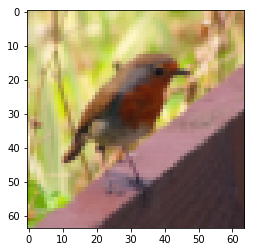

In [192]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [193]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [194]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [195]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [8]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [3]:
def model(X, Y, layers_dims, optimizer='gd', loss='cross', learning_rate = 0.0075, lambd = 0, keep_prob=1, mini_batch_size = 64,
          beta = 0.9, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, sparse_beta = 0, rho = 0, num_epochs = 10000,
          hidden_activation = None, output_activation = "sigmoid",  print_cost = True, classify=False):
    """
    L-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    np.random.seed(1)
    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]
    sparse_autoencoder_parameters = ()
    
    # Initialize parameters
    parameters = initialize_parameters_deep(layers_dims)#intype == "He"

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        
        if classify == True:
            global en1_parameters,test_x, test_y, train_x, train_y
            en1_parameters["W2"] = parameters["W1"]
            en1_parameters["b2"] = parameters["b1"]
            # Print the cost every 100 epoch
            predictions_train = predict(train_x, train_y, en1_parameters, hidden_activation="sigmoid", output_activation="softmax")
            predictions_test = predict(test_x.T, test_y.T, en1_parameters, hidden_activation="sigmoid", output_activation="softmax")
        
        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            AL, caches = L_model_forward(minibatch_X, parameters, keep_prob, hidden_activation, output_activation)
            #print(aL.shape)
            
            # Compute cost
            sparse_autoencoder_parameters = ()
            if rho != 0:
                A1 = caches[1][0][0]
                rho_hat = 1./m * np.sum(A1, axis = 1, keepdims = True)
                #print(rho_hat)
                #print(rho_hat.shape, A1.shape)
                sparse_autoencoder_parameters = (sparse_beta, rho, rho_hat)
                cost = compute_cost(AL, minibatch_Y, loss, parameters, lambd, sparse_autoencoder_parameters)
            # Backward propagation.
                grads = L_model_backward(AL, minibatch_Y, caches, loss, lambd, sparse_autoencoder_parameters, hidden_activation, output_activation)

            else:
                cost = compute_cost(AL, minibatch_Y, loss, parameters, lambd, sparse_autoencoder_parameters)
            # Backward propagation.                
                grads = L_model_backward(AL, minibatch_Y, caches, loss, lambd, sparse_autoencoder_parameters, hidden_activation, output_activation)

            # Backward propagation.
            assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                                # but here I will only explore one at a time

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                #learning_rate = learning_rate * (0.99**t)
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        #print(len(parameters)//2)

        if print_cost and i % 1 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
            #print ("accuracy after epoch %i: Train:%f, Test:%f" %(i, predictions_train, predictions_test))
        if print_cost and i % 1 == 0:
            costs.append(cost)
    #print("cache:",caches[-1][0][1])
    #print("W", parameters["W"+str(L-1)])
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
#     pred_test_x, caches = L_model_forward(test_x.T, parameters)
#     f, a = plt.subplots(2, 10, figsize=(20, 5))
#     for i in range(10):
#         a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
#         a[1][i].imshow(np.reshape(pred_test_x[:,i], (28, 28)))
#     plt.show()
    return parameters, caches

In [94]:
%%time
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

NameError: name 'L_layer_model' is not defined

In [204]:
%%time
parameters = model(train_x, train_y, layers_dims, optimizer="adam", learning_rate = 0.0075, mini_batch_size = 209, num_epochs = 2000, 
                   print_cost = True)

IndexError: index 210 is out of bounds for axis 1 with size 209

In [113]:
predictions_train = predict(train_x, train_y, parameters[0])

Accuracy: 0.9665071770334926


In [114]:
predictions_test = predict(test_x, test_y, parameters[0])

Accuracy: 0.7200000000000001


## Autoencoder

In [ ]:
def accuracy_eval(x_inputs, y_outputs, parameters):
    X = tf.placeholder(tf.float32, )
    

In [13]:
# Normalization
ae_train_x, x_mean, x_std = normalize(train_x_flatten)
#ae_test_x = 

print ("train_x's shape: " + str(ae_train_x.shape))
#print ("test_x's shape: " + str(ae_test_x.shape))

train_x's shape: (12288, 209)


In [4]:
import tensorflow as tf
from __future__ import division, print_function, absolute_import
from tensorflow.examples.tutorials.mnist import input_data

In [5]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=True) 

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


(784, 768)
(55000, 784)
(55000, 10)


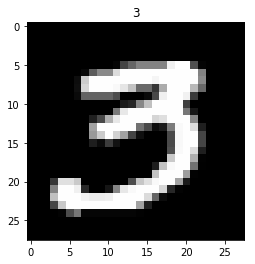

In [6]:
test_x = mnist.test.images[:200]
test_y = mnist.test.labels[:200]

train_x = mnist.train.images.T[:, :768]
train_y = mnist.train.labels.T[:, :768]
print(train_x.shape)
# plot one example
print(mnist.train.images.shape)     # (55000, 28 * 28)
print(mnist.train.labels.shape)     # (55000, 10)
plt.imshow(train_x[:,511].reshape((28, 28)), cmap='gray')
plt.title('%i' % np.argmax(train_y[:,511]))
plt.show()

Cost after epoch 0: 81.061989
Cost after epoch 1: 68.329073
Cost after epoch 2: 71.858245
Cost after epoch 3: 78.637436
Cost after epoch 4: 77.339399
Cost after epoch 5: 76.827924
Cost after epoch 6: 72.824392
Cost after epoch 7: 66.901947
Cost after epoch 8: 63.688520
Cost after epoch 9: 56.201585
Cost after epoch 10: 51.983938
Cost after epoch 11: 50.704775
Cost after epoch 12: 44.697718
Cost after epoch 13: 42.825962
Cost after epoch 14: 42.230516
Cost after epoch 15: 41.279811
Cost after epoch 16: 40.258278
Cost after epoch 17: 38.455485
Cost after epoch 18: 37.904968
Cost after epoch 19: 35.185578
Cost after epoch 20: 33.480388
Cost after epoch 21: 32.562022
Cost after epoch 22: 32.244930
Cost after epoch 23: 31.372869
Cost after epoch 24: 30.665404
Cost after epoch 25: 30.789749
Cost after epoch 26: 30.247188
Cost after epoch 27: 28.955435
Cost after epoch 28: 28.633912
Cost after epoch 29: 28.022338
Cost after epoch 30: 27.398506
Cost after epoch 31: 28.861383
Cost after epoch 3

Cost after epoch 265: 4.586986
Cost after epoch 266: 4.607783
Cost after epoch 267: 4.388276
Cost after epoch 268: 4.521109
Cost after epoch 269: 4.470189
Cost after epoch 270: 4.414736
Cost after epoch 271: 4.412279
Cost after epoch 272: 4.281176
Cost after epoch 273: 4.324642
Cost after epoch 274: 4.254787
Cost after epoch 275: 4.340723
Cost after epoch 276: 4.391498
Cost after epoch 277: 4.257794
Cost after epoch 278: 4.122584
Cost after epoch 279: 4.346223
Cost after epoch 280: 4.068197
Cost after epoch 281: 4.155406
Cost after epoch 282: 4.153843
Cost after epoch 283: 4.171946
Cost after epoch 284: 4.104539
Cost after epoch 285: 4.156466
Cost after epoch 286: 3.926167
Cost after epoch 287: 4.040485
Cost after epoch 288: 4.059397
Cost after epoch 289: 4.091215
Cost after epoch 290: 4.149944
Cost after epoch 291: 3.825612
Cost after epoch 292: 4.042575
Cost after epoch 293: 3.843097
Cost after epoch 294: 3.913744
Cost after epoch 295: 3.896702
Cost after epoch 296: 3.902142
Cost aft

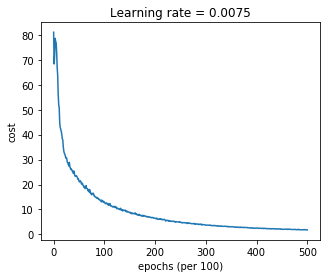

In [7]:
features_para, hidden_data_orig= model(train_x, train_x, (train_x.shape[0],256,train_x.shape[0]), optimizer="adam", learning_rate = 0.0075,
                                       mini_batch_size = 256, num_epochs = 501, print_cost = True, lambd = 0.0001, rho = 0.01, loss = 'square',
                                       keep_prob = 1, sparse_beta=3, hidden_activation="sigmoid", output_activation="sigmoid" )

In [8]:
pred_test_x, caches = L_model_forward(test_x.T, features_para,hidden_activation="sigmoid")

In [51]:
pred_test_x, caches = L_model_forward(test_x.T, en1_parameters,hidden_activation="sigmoid")

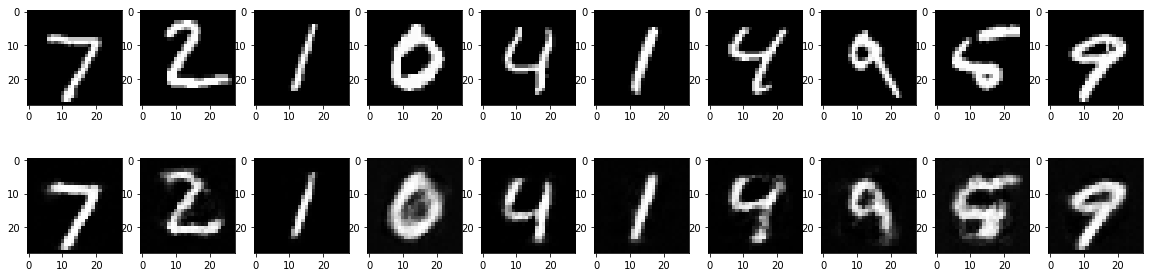

In [9]:
# for i in range(10):
    
#     plt.imshow(pred_test_x[:,i].reshape((28, 28)), cmap='gray')
#     plt.title('%i' % np.argmax(test_y[i]))
#     plt.show()
f, a = plt.subplots(2, 10, figsize=(20, 5))
for i in range(10):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(pred_test_x[:,i], (28, 28)))
plt.show()

In [68]:
en1_parameters = {}
en1_parameters["W1"] = features_para["W1"]
en1_parameters["b1"] = features_para["b1"]

In [66]:
np.save("sb1.npy", features_para['b1'])
np.save("sW1.npy", features_para['W1'])

In [69]:
en1_parameters["W1"][:5], en1_parameters["b1"][:5]
#en1_parameters["W1"].shape, en1_parameters["b1"].shape

(array([[ 0.05801233, -0.02184844, -0.01886328, ..., -0.03952047,
         -0.01282943,  0.01804935],
        [ 0.04349789, -0.06931003, -0.02879208, ...,  0.00740107,
         -0.05121538,  0.02238951],
        [ 0.01070804, -0.06630862, -0.07682297, ..., -0.06979256,
          0.00665085, -0.00013678],
        [-0.00161452,  0.01224451, -0.07731884, ...,  0.01822553,
         -0.00905783, -0.0163451 ],
        [-0.01092987,  0.0166342 , -0.00349913, ..., -0.02079347,
          0.00171   ,  0.01830242]]), array([[-1.79870152],
        [ 1.29791609],
        [-0.88130362],
        [ 1.68858946],
        [-0.45987868]]))

In [70]:
b1 = np.load("b1.npy")
W1 = np.load("W1.npy")
# b2 = np.load("b2.npy")
# W2 = np.load("W2.npy")
print(b1.shape, W1.shape)
b1[:5], W1[:5]

(256, 1) (256, 784)


(array([[-1.7987015 ],
        [ 1.297916  ],
        [-0.8813036 ],
        [ 1.6885895 ],
        [-0.45987868]], dtype=float32),
 array([[ 0.05801233, -0.02184844, -0.01886328, ..., -0.03952046,
         -0.01282943,  0.01804935],
        [ 0.04349789, -0.06931003, -0.02879208, ...,  0.00740107,
         -0.05121538,  0.02238951],
        [ 0.01070804, -0.06630863, -0.07682297, ..., -0.06979256,
          0.00665085, -0.00013678],
        [-0.00161452,  0.01224451, -0.07731884, ...,  0.01822554,
         -0.00905783, -0.01634509],
        [-0.01092988,  0.0166342 , -0.00349913, ..., -0.02079347,
          0.00171   ,  0.01830242]], dtype=float32))

In [76]:
en1_parameters["W1"] = W1
en1_parameters["b1"] = b1
# en1_parameters["W2"] = W2
# en1_parameters["b2"] = b2

In [241]:
hidden_data = hidden_data_orig[-1][0][0]
print(len(hidden_data_orig),len(hidden_data_orig[-1]),len(hidden_data_orig[-1][0]),hidden_data_orig[-1][0][1].shape,hidden_data.shape)

2 2 3 (784, 256) (256, 256)


In [10]:
hidden_data = linear_activation_forward(train_x, features_para["W1"], features_para["b1"], "sigmoid" )[0]
hidden_data.shape

(256, 768)

Accuracy:  0.0859375
Accuracy:  0.095
Cost after epoch 0: 1.940159
Accuracy:  0.5377604166666666
Accuracy:  0.495
Cost after epoch 1: 1.360201
Accuracy:  0.7356770833333334
Accuracy:  0.63
Cost after epoch 2: 1.021673
Accuracy:  0.8125
Accuracy:  0.745
Cost after epoch 3: 0.810443
Accuracy:  0.8216145833333334
Accuracy:  0.74
Cost after epoch 4: 0.665134
Accuracy:  0.8385416666666666
Accuracy:  0.785
Cost after epoch 5: 0.537141
Accuracy:  0.8606770833333334
Accuracy:  0.825
Cost after epoch 6: 0.521992
Accuracy:  0.8802083333333334
Accuracy:  0.835
Cost after epoch 7: 0.477191
Accuracy:  0.89453125
Accuracy:  0.835
Cost after epoch 8: 0.411180
Accuracy:  0.91015625
Accuracy:  0.84
Cost after epoch 9: 0.394912
Accuracy:  0.9153645833333334
Accuracy:  0.855
Cost after epoch 10: 0.343836
Accuracy:  0.9231770833333334
Accuracy:  0.855
Cost after epoch 11: 0.327985
Accuracy:  0.9296875
Accuracy:  0.855
Cost after epoch 12: 0.300142
Accuracy:  0.9375
Accuracy:  0.84
Cost after epoch 13: 0.2

Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 124: 0.020645
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 125: 0.019579
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 126: 0.020140
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 127: 0.018691
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 128: 0.019670
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 129: 0.019750
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 130: 0.020144
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 131: 0.018498
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 132: 0.018465
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 133: 0.015348
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 134: 0.016849
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 135: 0.017212
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 136: 0.016129
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 137: 0.015418
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 138: 0.018896
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 139: 0

Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 264: 0.007596
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 265: 0.006805
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 266: 0.006919
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 267: 0.006230
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 268: 0.006159
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 269: 0.006398
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 270: 0.005633
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 271: 0.005937
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 272: 0.006189
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 273: 0.005716
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 274: 0.005570
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 275: 0.006316
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 276: 0.006582
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 277: 0.006504
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 278: 0.005319
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 279: 0

Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 400: 0.003589
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 401: 0.002881
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 402: 0.003192
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 403: 0.003053
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 404: 0.003275
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 405: 0.002852
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 406: 0.003263
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 407: 0.003262
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 408: 0.003246
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 409: 0.003315
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 410: 0.003130
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 411: 0.003685
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 412: 0.003316
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 413: 0.002986
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 414: 0.003167
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 415: 0

Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 536: 0.002105
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 537: 0.001687
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 538: 0.002045
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 539: 0.002053
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 540: 0.002051
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 541: 0.002050
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 542: 0.002196
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 543: 0.001961
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 544: 0.001680
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 545: 0.002044
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 546: 0.002197
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 547: 0.002027
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 548: 0.001885
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 549: 0.002125
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 550: 0.002183
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 551: 0.00181

Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 671: 0.001177
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 672: 0.001149
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 673: 0.001336
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 674: 0.001347
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 675: 0.001507
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 676: 0.001228
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 677: 0.001204
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 678: 0.001327
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 679: 0.001323
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 680: 0.001364
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 681: 0.001247
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 682: 0.001181
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 683: 0.001246
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 684: 0.001154
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 685: 0.001232
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 686: 0.001422
Acc

Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 804: 0.000926
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 805: 0.000959
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 806: 0.000967
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 807: 0.000939
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 808: 0.000941
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 809: 0.000889
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 810: 0.000890
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 811: 0.000959
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 812: 0.000851
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 813: 0.000905
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 814: 0.000904
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 815: 0.000700
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 816: 0.001013
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 817: 0.000911
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 818: 0.000990
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 819: 0.000883
Accuracy

Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 940: 0.000608
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 941: 0.000615
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 942: 0.000585
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 943: 0.000712
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 944: 0.000733
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 945: 0.000693
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 946: 0.000617
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 947: 0.000705
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 948: 0.000642
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 949: 0.000651
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 950: 0.000594
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 951: 0.000630
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 952: 0.000727
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 953: 0.000652
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 954: 0.000678
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 955: 0.000656
Accuracy

Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1074: 0.000499
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 1075: 0.000506
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1076: 0.000543
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 1077: 0.000562
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 1078: 0.000505
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 1079: 0.000542
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 1080: 0.000516
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 1081: 0.000495
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 1082: 0.000509
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 1083: 0.000477
Accuracy:  1.0
Accuracy:  0.85
Cost after epoch 1084: 0.000478
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1085: 0.000506
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1086: 0.000501
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1087: 0.000546
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1088: 0.000491
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 

Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1209: 0.000369
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1210: 0.000394
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1211: 0.000406
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1212: 0.000405
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1213: 0.000426
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1214: 0.000351
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1215: 0.000325
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1216: 0.000301
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1217: 0.000442
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1218: 0.000387
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1219: 0.000396
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1220: 0.000337
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1221: 0.000393
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1222: 0.000393
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1223: 0.000384
Accuracy:  1.0
Accuracy:  0.855
Cost aft

Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1343: 0.000307
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1344: 0.000316
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1345: 0.000323
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1346: 0.000304
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1347: 0.000318
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1348: 0.000302
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1349: 0.000301
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1350: 0.000281
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1351: 0.000296
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1352: 0.000321
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1353: 0.000312
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1354: 0.000298
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1355: 0.000267
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1356: 0.000266
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1357: 0.000339
Accuracy:  1.0
Accuracy:  0.855
Cost aft

Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1473: 0.000236
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1474: 0.000234
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1475: 0.000247
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1476: 0.000218
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1477: 0.000265
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1478: 0.000301
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1479: 0.000273
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1480: 0.000256
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1481: 0.000270
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1482: 0.000247
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1483: 0.000248
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1484: 0.000236
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1485: 0.000194
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1486: 0.000262
Accuracy:  1.0
Accuracy:  0.855
Cost after epoch 1487: 0.000223
Accuracy:  1.0
Accuracy:  0.855
Cost aft

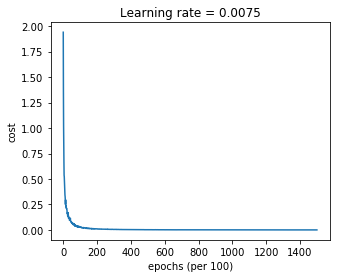

In [77]:
soft_para, hidden_data_orig2= model(hidden_data, train_y, (hidden_data.shape[0],10), optimizer="adam",
                                     mini_batch_size = 256, num_epochs = 1501, print_cost = True, learning_rate = 0.0075, loss="softmax",
                                     lambd = 0, rho = 0, sparse_beta=3, output_activation="softmax")

In [279]:
en1_parameters["W2"] = soft_para["W1"]
en1_parameters["b2"] = soft_para["b1"]
en1_parameters.keys()

dict_keys(['b2', 'b1', 'W2', 'W1'])

In [74]:
en1_parameters.keys()

dict_keys(['W1', 'W2', 'b2', 'b1'])

In [75]:
del en1_parameters["W2"]
del en1_parameters["b2"]

In [48]:
predictions_train = predict(train_x, train_y, en1_parameters, hidden_activation="sigmoid", output_activation="softmax")
predictions_test = predict(test_x.T, test_y.T, en1_parameters, hidden_activation="sigmoid", output_activation="softmax")

Accuracy:  0.0
Accuracy:  0.0


In [ ]:
output_para, hidden_data_orig2= model(hidden_data, train_y, (hidden_data.shape[0],10), optimizer="adam",
                                     mini_batch_size = 256, num_epochs = 1501, print_cost = True, learning_rate = 0.0075, loss="softmax",
                                     lambd = 0, rho = 0, sparse_beta=3, hidden_activation="sigmoid", output_activation="softmax")

Cost after epoch 0: 12.217273
Cost after epoch 100: 0.640611
Cost after epoch 200: 0.377571
Cost after epoch 300: 0.337906
Cost after epoch 400: 0.304949
Cost after epoch 500: 0.282636
Cost after epoch 600: 0.275469
Cost after epoch 700: 0.260373
Cost after epoch 800: 0.256443
Cost after epoch 900: 0.246679
Cost after epoch 1000: 0.250553
Cost after epoch 1100: 0.243890
Cost after epoch 1200: 0.250153
Cost after epoch 1300: 0.232446
Cost after epoch 1400: 0.229293
Cost after epoch 1500: 0.245290


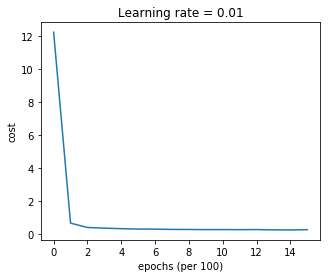

In [243]:
features_para2, hidden_data_orig2= model(hidden_data, hidden_data, (hidden_data.shape[0],128,hidden_data.shape[0]), optimizer="adam",
                                         mini_batch_size = 256, num_epochs = 1501, print_cost = True, learning_rate = 0.01, loss="square",
                                         lambd = 0, rho = 0, sparse_beta=3)

In [244]:
en1_parameters["W4"] = features_para["W2"]# en1_parameters.pop("W4")
en1_parameters["b4"] = features_para["b2"]# en1_parameters.pop("b4")

In [245]:
en1_parameters["W2"] = features_para2["W1"]
en1_parameters["b2"] = features_para2["b1"]
en1_parameters["W3"] = features_para2["W2"]
en1_parameters["b3"] = features_para2["b2"]

In [246]:
en1_parameters.keys()

dict_keys(['b4', 'b3', 'b1', 'W2', 'W4', 'W3', 'b2', 'W1'])

In [247]:
pred_test_x, caches = L_model_forward(test_x.T, en1_parameters)

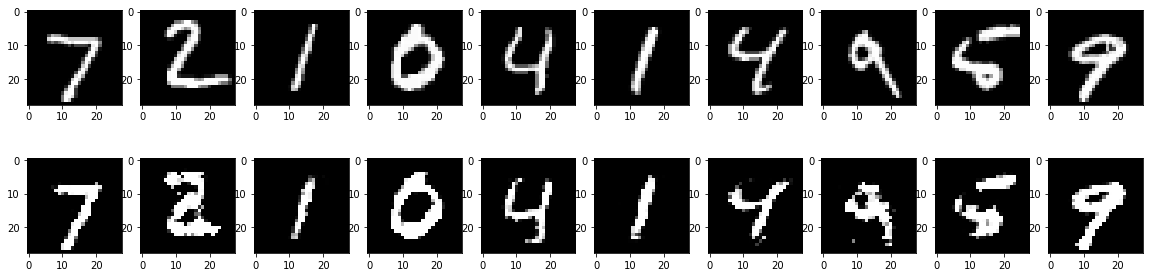

In [248]:
f, a = plt.subplots(2, 10, figsize=(20, 5))
for i in range(10):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(pred_test_x[:,i], (28, 28)))
plt.show()

Cost after epoch 0: 2180.696842
Cost after epoch 2: 964.841900
cache: [[ 0.02540123 -0.01014253 -0.03158018 ... -0.04130559 -0.06055433
  -0.03918234]
 [ 0.01363885 -0.00336531 -0.00052389 ... -0.01747628  0.01342284
  -0.03532722]
 [ 0.01717969  0.00191679 -0.03179904 ...  0.01437471 -0.02163308
  -0.00749714]
 ...
 [-0.04774558 -0.03029633  0.01968395 ... -0.03341028 -0.0178472
  -0.02177287]
 [ 0.07407399  0.02015223 -0.00611265 ... -0.03569501 -0.02895603
   0.0130572 ]
 [-0.00134664 -0.02393647  0.01084041 ... -0.03122516  0.0018683
  -0.01674217]]
W [[ 0.02540123 -0.01014253 -0.03158017 ... -0.04130559 -0.06055433
  -0.03918234]
 [ 0.01363885 -0.00336531 -0.00052389 ... -0.01747628  0.01342284
  -0.03532722]
 [ 0.01717969  0.00191679 -0.03179904 ...  0.01437471 -0.02163308
  -0.00749714]
 ...
 [-0.04774558 -0.03029633  0.01968395 ... -0.03341028 -0.0178472
  -0.02177286]
 [ 0.07407399  0.02015223 -0.00611265 ... -0.035695   -0.02895603
   0.0130572 ]
 [-0.00134664 -0.02393647  0.

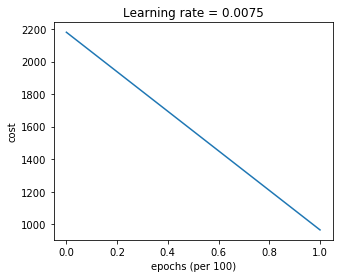

In [17]:
features_para = model(ae_train_x, ae_train_x, (ae_train_x.shape[0],1000,ae_train_x.shape[0]), mini_batch_size = 209, 
                      num_epochs = 4, print_cost = True, lambd = 0.001, rho = 0.01, sparse_beta=3 )

In [11]:
features_para = model(ae_train_x, ae_train_x, (ae_train_x.shape[0],1000,ae_train_x.shape[0]), mini_batch_size = 209,
                      num_epochs = 2500, print_cost = True, lambd = 0.001, rho = 0.01, sparse_beta=3 )

0 175.756195142 0.0317815205368 2004.90886577
Cost after epoch 0: 2180.696842
0 85.985972858 0.0328071844727 899.611235421
0 85.9821879677 0.0327692700121 878.826942637


KeyboardInterrupt: 

In [16]:
predictions_train = predict(train_x, train_y, features_para)

Accuracy: 0.9999999999999998


In [17]:
predictions_test = predict(test_x, test_y, features_para)

Accuracy: 0.74


## Test 2-D Data

In [60]:
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

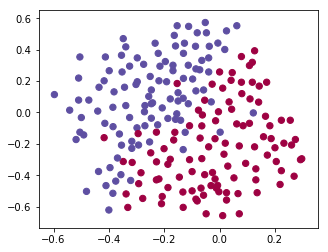

In [76]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [88]:
def plot_decision_boundary(pmodel, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pmodel(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = L_model_forward(X, parameters)
    predictions = (a3>0.5)
    return predictions

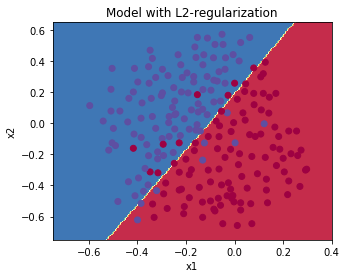

In [107]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(features_para, x.T), train_X, train_Y)

In [128]:
te = {}
if te:
    print(type(te))

In [164]:
tuple0 = (1,2,3)
tuple1 = tuple0 + tuple(np.ndarray([1,2,3]))

In [165]:
tuple1

(1, 2, 3, array([[1202.42372881,   61.48459168, 1204.42372881],
        [ 155.06086287, 1298.        ,   62.48459168]]))